In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from crf.comlid_crf import *
from helper.dataset_reader import read_tsv

In [2]:
from tensorflow.python.client import device_lib

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.0
GPU detected: []


In [3]:
langid = LanguageIdentifier()

In [4]:
data = read_tsv('../dataset/all-merged-data-140422.tsv')

In [5]:
all_data, words, tags = data

In [6]:
# create list of tuples from all words and all tags
word_tag = list(zip(words, tags))
# print(word_tag)
# convert list to dataframe
df_wordtag = pd.DataFrame(word_tag, columns=['Token','Label'])
# df_wordtag

In [7]:
words = list(set(df_wordtag['Token'].values))
words.append("ENDPAD")
num_words = len(words)
# print(num_words)

In [8]:
tags = list(set(df_wordtag["Label"].values))
num_tags = len(tags)
# print(num_tags)

In [9]:
dt_pair = langid.data_transformer(data)
# dt_pair[0]

In [10]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

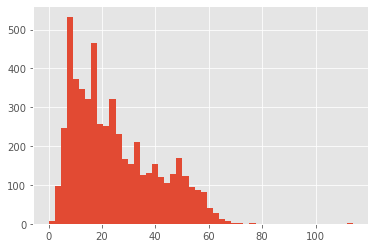

In [11]:
plt.hist([len(s) for s in dt_pair], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in dt_pair]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in dt_pair]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 7)            1407      
 ibuted)                                                         
                                                             

In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

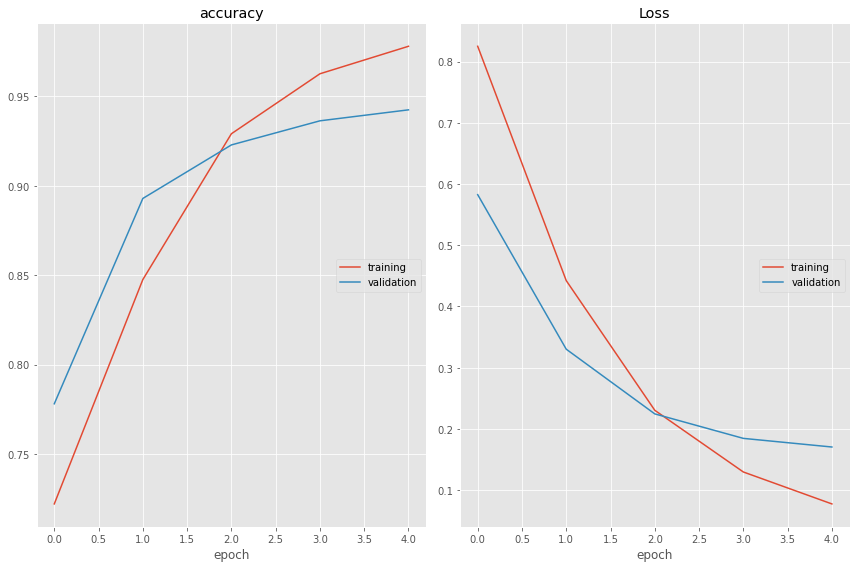

accuracy
	training         	 (min:    0.722, max:    0.978, cur:    0.978)
	validation       	 (min:    0.778, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.078, max:    0.825, cur:    0.078)
	validation       	 (min:    0.170, max:    0.583, cur:    0.170)

Epoch 5: val_loss improved from 0.18458 to 0.17048, saving model to ../model/model_weights.h5
113/113 [==============================] - 8s 70ms/step - loss: 0.0775 - accuracy: 0.9781 - val_loss: 0.1705 - val_accuracy: 0.9425
CPU times: user 2min 59s, sys: 53.4 s, total: 3min 52s
Wall time: 44.6 s


In [18]:
%%time

chkpt = ModelCheckpoint("../model/model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

In [19]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 1s 11ms/step - loss: 0.1705 - accuracy: 0.9425


[0.17048059403896332, 0.9425154328346252]

In [20]:
idx2tag = {i: w for w,i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        for p in pred_i:
            p_i = np.argmax(p)
            out.append(idx2tag[p_i].replace("ENDPAD", "O"))

    return out

def test2label(y_test):
    tags = []
    for val in y_test:
        for v in val:
            tags.append(idx2tag[v])

    return tags

y_test_pred = test2label(y_test)

In [21]:
y_pred = model.predict(x_test, verbose=1)
y_pred = pred2label(y_pred)

56/56 [==============================] - 1s 10ms/step


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ['ID', 'JV', 'EN', 'MIX-ID-EN', 'MIX-ID-JV', 'MIX-JV-EN', 'O']

print(classification_report(y_test_pred, y_pred, labels=labels))

              precision    recall  f1-score   support

          ID       0.90      0.95      0.93     21495
          JV       0.80      0.84      0.82      4734
          EN       0.85      0.87      0.86      5202
   MIX-ID-EN       0.84      0.73      0.78       996
   MIX-ID-JV       1.00      0.01      0.02       318
   MIX-JV-EN       0.95      0.15      0.26       238
           O       0.98      0.97      0.97     56067

    accuracy                           0.94     89050
   macro avg       0.90      0.65      0.66     89050
weighted avg       0.94      0.94      0.94     89050



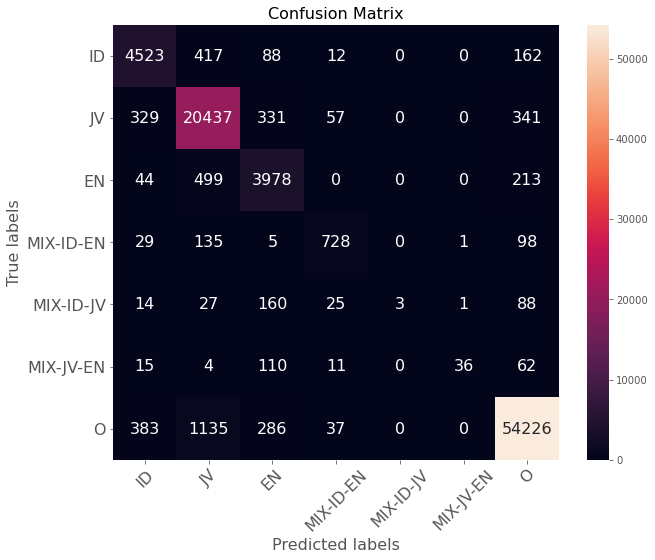

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_pred, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', ax=ax)
fig, ax = plt.subplots(figsize=(10,8))

# plt.figure(figsize=(12, 10))
# sns.set(rc={'figure.figsize': (14, 12)})
sns.heatmap(cm, annot=True, fmt='d', ax=ax, annot_kws={'size': 16})
# annot=True to annotate cells, ftm='g' to disable scientific notation


# labels, title and ticks
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted labels', fontsize=16)
ax.set_ylabel('True labels', fontsize=16)
ax.xaxis.set_ticklabels(labels, rotation=45, fontsize=16)
ax.yaxis.set_ticklabels(labels, rotation=0, fontsize=16)

plt.show()

In [40]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 22ms/step
Word                          True      	 Pred

------------------------------------------------------------
risih                         ID        	ID
gak                           ID        	ID
to                            JV        	EN
di                            ID        	ID
akun                          ID        	ID
pertama                       ID        	ID
nge                           ID        	ID
twt                           EN        	O
apa                           ID        	ID
dikit                         ID        	ID
langsung                      ID        	ID
di                            ID        	ID
wa                            O         	O
"                             O         	O
meh                           JV        	JV
ngopo                         JV        	JV
",                            O         	O
emang                         ID        	ID
paling                        ID        	ID
enak   